# 🧪 Skin Disease Classification Using InceptionV3 (Supplementary Notebook)

This notebook is part of the supplementary materials for the manuscript:

**A website-based skin disease identification using a Convolutional Neural Network for childcare applications (2025)**

This notebook demonstrates:
- Nested 5-fold cross-validation with 3 experiment settings:
  - with augmentation
  - without augmentation
  - with augmentation & 50% training data
- Transfer learning using InceptionV3  
- Training on four skin disease classes  
- Code required for reproducibility  

---


# ===============================================
# IMPORTANT: UPDATE DATASET PATH BEFORE RUNNING
# ===============================================
# This notebook was originally developed in Google Colab.
# If you are running it locally or on another environment,
# PLEASE CHANGE the base_dir below to the folder that contains:
#    train/  val/  test/
#
# Example paths:
#   - Local machine:  base_dir = "C:/datasets/skin/"
#   - Linux server:   base_dir = "/home/user/skin_dataset/"
#   - Colab (your own drive):  base_dir = "/content/drive/MyDrive/your_dataset/"
#
# After updating, ensure the structure is:
#   base_dir/
#      ├── training/
#      ├── validation/
#      └── testing/
# ===============================================




Example of path can be copied from Colab

In [ ]:
base_dir = "/content/drive/MyDrive/your_dataset/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model,load_model
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
##from sklearn import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import itertools
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold, train_test_split
from glob import glob
from tqdm import tqdm

#Update correct path to base_dir

In [ ]:
# -------------------
# Step 1: Load and Merge Images from train/ val/ test/
# -------------------
base_dir = "/content/drive/MyDrive/Skin/Hakimi dataset/"  # replace with your root folder that has train/, val/, test/
folders = ["training", "validation", "testing"]

img_size = (299, 299)  # InceptionV3 default
X, y = [], []

class_names = sorted(os.listdir(os.path.join(base_dir, "training")))
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

for split in folders:
    for cls in class_names:
        img_paths = glob(os.path.join(base_dir, split, cls, "*"))
        for img_path in tqdm(img_paths, desc=f"Loading {split}/{cls}"):
            try:
                img = load_img(img_path, target_size=img_size)
                img = img_to_array(img)
                X.append(img)
                y.append(class_to_idx[cls])
            except:
                print("Skipped:", img_path)

X = np.array(X, dtype="float32")
y = np.array(y)
print("Dataset shape:", X.shape, y.shape)



Loading testing/Herpes Zoster: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]

Dataset shape: (520, 299, 299, 3) (520,)


In [ ]:
X.shape, y.shape

((520, 299, 299, 3), (520,))

In [ ]:
 -------------------
# Build Model
# -------------------
def build_model(input_shape=(299, 299, 3), num_classes=4, lr=1e-4):

    pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base model (same as single split)
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Use 'mixed5' layer EXACTLY like your single split
    last_layer = pre_trained_model.get_layer('mixed5')  #
    last_output = last_layer.output

    # Same custom top layers
    x = Flatten()(last_output)                        #
    x = Dense(512, activation='relu')(x)              #
    x = Dropout(0.2)(x)                               #
    x = Dense(num_classes,activation='softmax')(x)

    model = Model(pre_trained_model.input, x)

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
        loss="categorical_crossentropy", #
        metrics=["accuracy"]
    )
    return model

# -------------------
# Bootstrap CI (pooled)
# -------------------
def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=1000, confidence=0.95, random_state=None):
    rng = np.random.default_rng(random_state)
    scores = []
    n = len(y_true)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)  # bootstrap indices
        yt = y_true[idx]
        yp = y_pred[idx]
        scores.append(metric_fn(yt, yp))
    scores = np.array(scores)
    mean = scores.mean()
    low = np.percentile(scores, (1-confidence)/2*100)
    high = np.percentile(scores, (1 + confidence)/2*100)
    return mean, (low, high)


# -------------------
# Compute fold-based stats
# -------------------
def compute_fold_stats(metrics_list):
    stats = {}
    for k in metrics_list[0].keys():
        vals = [m[k] for m in metrics_list]
        stats[k] = {"mean": np.mean(vals), "std": np.std(vals)}
    return stats

# ✅ Correct - add the function
def resize_image_arrays(X, target_size=(299, 299)):
    resized_images = []
    for img in X:
        resized_img = tf.image.resize(img, target_size).numpy()
        resized_images.append(resized_img)
    return np.array(resized_images)
# -------------------
# Run experiment
# -------------------
def run_experiment(X, y, class_names, use_aug=True, subset_frac=1.0,
                   batch_size=8, epochs=100):

    # ✅ Define target_size
    target_size = (299, 299)

    # ✅ Convert sparse labels to one-hot encoding
    y_onehot = to_categorical(y, num_classes=len(class_names))

    # ✅ Resize all images if needed
    if X.shape[1:3] != target_size:
        print(f"Resizing images from {X.shape[1:3]} to {target_size}")
        X_resized = resize_image_arrays(X, target_size)
    else:
        X_resized = X

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_metrics_list = []
    all_y_true, all_y_pred, all_y_prob = [], [], []

    for fold, (train_idx, val_test_idx) in enumerate(kf.split(X_resized, y), 1):
        print(f"\n--- Fold {fold} ---")

        # Holdout test split
        # Split: 80% train_val, 20% test_val (matches single split)
        X_train, X_val_test = X_resized[train_idx], X_resized[val_test_idx]
        y_train_onehot, y_val_test_onehot = y_onehot[train_idx], y_onehot[val_test_idx]
        y_train_sparse, y_val_test_sparse = y[train_idx], y[val_test_idx]  # Keep sparse for metrics

        # Optional subset
        if subset_frac < 1.0:
            sub_idx = np.random.choice(len(X_train),
                                       int(len(X_train)*subset_frac),
                                       replace=False)
            X_train = X_train[sub_idx]
            y_train_onehot = y_train_onehot[sub_idx]
            y_train_sparse = y_train_sparse[sub_idx]

        # ✅ CORRECT: Split ONCE and get both label formats
        # Get indices for the split
        X_val_test_temp = np.arange(len(X_val_test))  # Create index array

        # Split indices instead of data
        val_idx, test_idx = train_test_split(
            X_val_test_temp,
            test_size=0.5,
            stratify=y_val_test_sparse,  # Use sparse for stratification
            random_state=42
        )

        # Now apply the same indices to get all versions
        X_val, X_test = X_val_test[val_idx], X_val_test[test_idx]
        y_val_onehot, y_test_onehot = y_val_test_onehot[val_idx], y_val_test_onehot[test_idx]
        y_val_sparse, y_test_sparse = y_val_test_sparse[val_idx], y_val_test_sparse[test_idx]

        print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
        print(f"Val: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
        print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

        # ✅ VERIFY they match
        print(f"Verification - Test set labels match: {np.array_equal(np.argmax(y_test_onehot, axis=1), y_test_sparse)}")
        # Data augmentation / normalization

        if use_aug:
            train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                               rotation_range=30,
                                               width_shift_range=0.1,
                                               height_shift_range=0.1,
                                               shear_range=0.2,
                                               zoom_range=0.2,
                                               horizontal_flip=True)
        else:
            train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input )

        val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

        train_gen = train_datagen.flow(X_train, y_train_onehot, batch_size=batch_size,shuffle=True)
        val_gen = val_datagen.flow(X_val, y_val_onehot, batch_size=batch_size,shuffle=False)
        test_gen = test_datagen.flow(X_test, y_test_onehot, batch_size=batch_size, shuffle=False)

        # Build and train model
        model = build_model(input_shape=X_resized.shape[1:], num_classes=len(class_names))

        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        checkpoint = ModelCheckpoint(f'best_model_fold{fold}.h5', monitor='val_loss', save_best_only=True, verbose=1)

        history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                            callbacks=[early_stop, checkpoint], verbose=1)

        # Plot training curve
        plt.figure()
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'Accuracy Curve - Fold {fold}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        # Evaluate on test
        y_prob = model.predict(test_gen)
        y_pred = np.argmax(y_prob, axis=1)

        all_y_true.extend(y_test_sparse)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)

        # Fold metrics
        fold_metrics = {
            "accuracy": accuracy_score(y_test_sparse, y_pred),
            "precision": precision_score(y_test_sparse, y_pred, average="macro"),
            "recall": recall_score(y_test_sparse, y_pred, average="macro"),
            "f1": f1_score(y_test_sparse, y_pred, average="macro"),
            "auc": roc_auc_score(y_test_onehot, y_prob, multi_class="ovr")
        }
        fold_metrics_list.append(fold_metrics)

    # ----- Fold-based stats -----
    fold_stats = compute_fold_stats(fold_metrics_list)
    print("\n===== Fold-based CV Results (mean ± std) =====")
    for k, v in fold_stats.items():
        print(f"{k}: {v['mean']:.4f} ± {v['std']:.4f}")

    # ----- Pooled metrics with bootstrap CI -----
    print("\n===== Pooled Metrics (95% CI via bootstrapping) =====")
    acc_mean, acc_ci = bootstrap_ci(all_y_true, all_y_pred, accuracy_score)
    prec_mean, prec_ci = bootstrap_ci(all_y_true, all_y_pred,
                                      lambda yt, yp: precision_score(yt, yp, average="macro"))
    recall_mean, recall_ci = bootstrap_ci(all_y_true, all_y_pred,
                                         lambda yt, yp: recall_score(yt, yp, average="macro"))
    f1_mean, f1_ci = bootstrap_ci(all_y_true, all_y_pred,
                                   lambda yt, yp: f1_score(yt, yp, average="macro"))
    all_y_prob_arr = np.array(all_y_prob)
  # compute pooled AUC CI
    auc_mean, auc_ci = bootstrap_ci(
      all_y_true,
      all_y_prob_arr,
      lambda yt, yp: roc_auc_score(to_categorical(yt, len(class_names)), yp, multi_class='ovr'),
      n_boot=2000,
      random_state=42
    )

    print(f"Accuracy: {acc_mean:.3f} (95% CI: {acc_ci[0]:.3f}–{acc_ci[1]:.3f})")
    print(f"Precision: {prec_mean:.3f} (95% CI: {prec_ci[0]:.3f}–{prec_ci[1]:.3f})")
    print(f"Recall: {recall_mean:.3f} (95% CI: {recall_ci[0]:.3f}–{recall_ci[1]:.3f})")
    print(f"F1-score: {f1_mean:.3f} (95% CI: {f1_ci[0]:.3f}–{f1_ci[1]:.3f})")
    print(f"AUC: {auc_mean:.3f} (95% CI: {auc_ci[0]:.3f}–{auc_ci[1]:.3f})")

    # ----- Confusion matrix (pooled) -----
    avg_cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Pooled Confusion Matrix (Test Sets)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ----- Per-class metrics -----
    pooled_report = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
    print("\n===== Per-Class Metrics (Pooled) =====")
    for cls in class_names:
        print(f"{cls:15s} | Precision: {pooled_report[cls]['precision']:.3f} "
              f"Recall: {pooled_report[cls]['recall']:.3f} "
              f"F1: {pooled_report[cls]['f1-score']:.3f}")

    # ----- ROC curves (pooled) -----
    y_true_cat = to_categorical(all_y_true, num_classes=len(class_names))
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_cat[:,i], np.array(all_y_prob)[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Pooled Test Sets)")
    plt.legend()
    plt.show()


#With Augmentation


--- Fold 1 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3481 - loss: 9.0888
Epoch 1: val_loss improved from inf to 2.24376, saving model to best_model_fold1.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 361ms/step - accuracy: 0.3495 - loss: 9.0151 - val_accuracy: 0.5385 - val_loss: 2.2438
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6567 - loss: 1.4929
Epoch 2: val_loss improved from 2.24376 to 1.11186, saving model to best_model_fold1.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.6566 - loss: 1.4892 - val_accuracy: 0.5769 - val_loss: 1.1119
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6344 - loss: 1.0251
Epoch 3: val_loss improved from 1.11186 to 0.86853, saving model to best_model_fold1.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.6346 - loss: 1.0248 - val_accuracy: 0.6154 - val_loss: 0.8685
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7242 - loss: 0.8294
Epoch 4: val_loss did not improve from 0.86853
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7240 - loss: 0.8307 - val_accuracy: 0.6346 - val_loss: 1.3177
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7000 - loss: 0.8682
Epoch 5: val_loss did not improve from 0.86853
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7007 - loss: 0.8665 - val_accuracy: 0.7692 - val_loss: 1.0924
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7594 - loss: 0.7129
Epoch 6: val_loss did not improve from 0.86853
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7595 - loss: 0.7117 - val_accuracy: 0.7115 - val_loss: 0.9899
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8165 - loss: 0.5435
Epoch 7: val_loss improved from 0.86853 to

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.8163 - loss: 0.5449 - val_accuracy: 0.7308 - val_loss: 0.7067
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8232 - loss: 0.5141
Epoch 8: val_loss did not improve from 0.70673
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.8231 - loss: 0.5153 - val_accuracy: 0.7308 - val_loss: 0.7551
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8529 - loss: 0.4669
Epoch 9: val_loss did not improve from 0.70673
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8527 - loss: 0.4681 - val_accuracy: 0.7692 - val_loss: 0.7581
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8961 - loss: 0.3056
Epoch 10: val_loss did not improve from 0.70673
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8958 - loss: 0.3064 - val_accuracy: 0.7500 - val_loss: 0.7338
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8913 - loss: 0.3123
Epoch 11: val_loss did not improve from

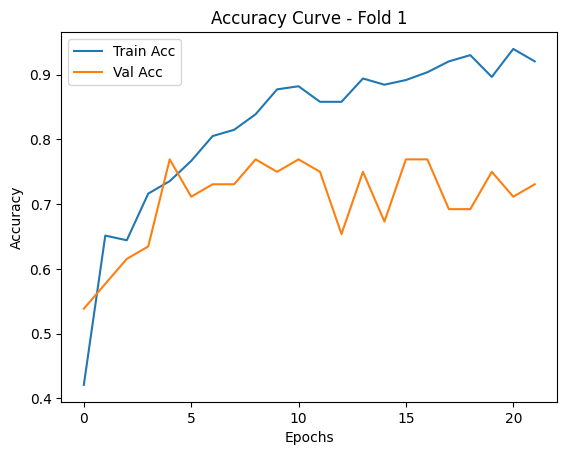

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 590ms/step

--- Fold 2 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3760 - loss: 9.2662
Epoch 1: val_loss improved from inf to 2.22346, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 301ms/step - accuracy: 0.3764 - loss: 9.2037 - val_accuracy: 0.5577 - val_loss: 2.2235
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4976 - loss: 2.1506
Epoch 2: val_loss improved from 2.22346 to 1.33608, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.4989 - loss: 2.1427 - val_accuracy: 0.5962 - val_loss: 1.3361
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6719 - loss: 1.0704
Epoch 3: val_loss improved from 1.33608 to 0.82482, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.6719 - loss: 1.0710 - val_accuracy: 0.6923 - val_loss: 0.8248
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6937 - loss: 0.9281
Epoch 4: val_loss did not improve from 0.82482
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.6938 - loss: 0.9292 - val_accuracy: 0.6154 - val_loss: 1.1780
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7472 - loss: 0.7665
Epoch 5: val_loss improved from 0.82482 to 0.78571, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.7468 - loss: 0.7677 - val_accuracy: 0.7115 - val_loss: 0.7857
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7786 - loss: 0.6995
Epoch 6: val_loss did not improve from 0.78571
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.7780 - loss: 0.7003 - val_accuracy: 0.5769 - val_loss: 1.4954
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8142 - loss: 0.5857
Epoch 7: val_loss did not improve from 0.78571
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8141 - loss: 0.5864 - val_accuracy: 0.5962 - val_loss: 1.0142
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7765 - loss: 0.5881
Epoch 8: val_loss improved from 0.78571 to 0.59776, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.7765 - loss: 0.5887 - val_accuracy: 0.8077 - val_loss: 0.5978
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8259 - loss: 0.5156
Epoch 9: val_loss did not improve from 0.59776
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8257 - loss: 0.5163 - val_accuracy: 0.6538 - val_loss: 1.5136
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8386 - loss: 0.5776
Epoch 10: val_loss improved from 0.59776 to 0.42390, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.8389 - loss: 0.5762 - val_accuracy: 0.7885 - val_loss: 0.4239
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8252 - loss: 0.5103
Epoch 11: val_loss did not improve from 0.42390
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8252 - loss: 0.5110 - val_accuracy: 0.7692 - val_loss: 0.4792
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8265 - loss: 0.4597
Epoch 12: val_loss did not improve from 0.42390
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8266 - loss: 0.4593 - val_accuracy: 0.7115 - val_loss: 0.7743
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8926 - loss: 0.3467
Epoch 13: val_loss did not improve from 0.42390
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8923 - loss: 0.3473 - val_accuracy: 0.8269 - val_loss: 0.5311
Epoch 14/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9151 - loss: 0.3046
Epoch 14: val_loss did not improve 

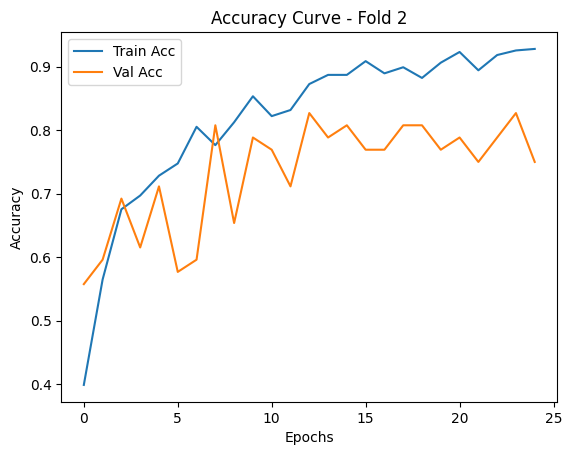

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 591ms/step

--- Fold 3 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3324 - loss: 9.1621
Epoch 1: val_loss improved from inf to 2.22588, saving model to best_model_fold3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - accuracy: 0.3337 - loss: 9.1035 - val_accuracy: 0.5385 - val_loss: 2.2259
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5914 - loss: 2.2641
Epoch 2: val_loss improved from 2.22588 to 1.87227, saving model to best_model_fold3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.5912 - loss: 2.2637 - val_accuracy: 0.6346 - val_loss: 1.8723
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6171 - loss: 1.9209
Epoch 3: val_loss improved from 1.87227 to 1.51148, saving model to best_model_fold3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.6178 - loss: 1.9141 - val_accuracy: 0.7115 - val_loss: 1.5115
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6699 - loss: 1.1831
Epoch 4: val_loss improved from 1.51148 to 1.20322, saving model to best_model_fold3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.6702 - loss: 1.1820 - val_accuracy: 0.6923 - val_loss: 1.2032
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7280 - loss: 0.9627
Epoch 5: val_loss did not improve from 1.20322
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.7276 - loss: 0.9632 - val_accuracy: 0.7115 - val_loss: 1.3970
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7453 - loss: 0.8220
Epoch 6: val_loss did not improve from 1.20322
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7451 - loss: 0.8224 - val_accuracy: 0.7115 - val_loss: 1.2204
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7720 - loss: 0.8419
Epoch 7: val_loss did not improve from 1.20322
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.7724 - loss: 0.8384 - val_accuracy: 0.6346 - val_loss: 1.8787
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8160 - loss: 0.6327
Epoch 8: val_loss improved from 1.20322 to

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.8154 - loss: 0.6341 - val_accuracy: 0.7500 - val_loss: 0.9302
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8179 - loss: 0.6242
Epoch 9: val_loss did not improve from 0.93018
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8177 - loss: 0.6240 - val_accuracy: 0.7115 - val_loss: 1.0965
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7691 - loss: 0.6785
Epoch 10: val_loss improved from 0.93018 to 0.92828, saving model to best_model_fold3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.7692 - loss: 0.6787 - val_accuracy: 0.7500 - val_loss: 0.9283
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8448 - loss: 0.4702
Epoch 11: val_loss did not improve from 0.92828
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8446 - loss: 0.4726 - val_accuracy: 0.7308 - val_loss: 0.9303
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8799 - loss: 0.3740
Epoch 12: val_loss did not improve from 0.92828
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8799 - loss: 0.3738 - val_accuracy: 0.7500 - val_loss: 1.4282
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8603 - loss: 0.4062
Epoch 13: val_loss did not improve from 0.92828
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.8604 - loss: 0.4063 - val_accuracy: 0.6538 - val_loss: 1.3711
Epoch 14/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8983 - loss: 0.2616
Epoch 14: val_loss did not improve f

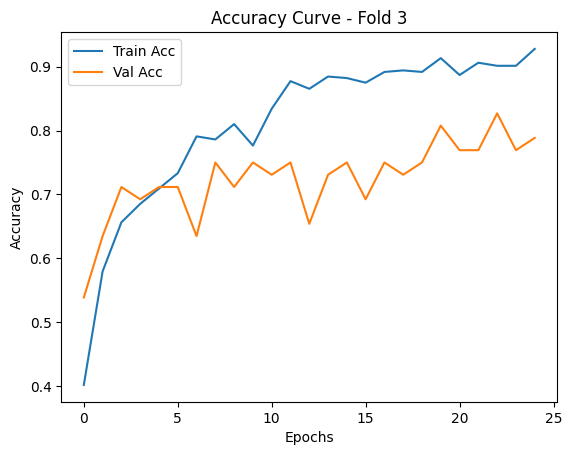

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 592ms/step

--- Fold 4 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3676 - loss: 9.0702
Epoch 1: val_loss improved from inf to 1.42925, saving model to best_model_fold4.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 304ms/step - accuracy: 0.3684 - loss: 9.0066 - val_accuracy: 0.5577 - val_loss: 1.4293
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4426 - loss: 2.1882
Epoch 2: val_loss improved from 1.42925 to 0.99910, saving model to best_model_fold4.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.4437 - loss: 2.1818 - val_accuracy: 0.6731 - val_loss: 0.9991
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6432 - loss: 1.0390
Epoch 3: val_loss did not improve from 0.99910
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.6425 - loss: 1.0409 - val_accuracy: 0.6154 - val_loss: 1.0093
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6868 - loss: 0.7978
Epoch 4: val_loss improved from 0.99910 to 0.72310, saving model to best_model_fold4.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.6866 - loss: 0.7995 - val_accuracy: 0.7500 - val_loss: 0.7231
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7595 - loss: 0.6735
Epoch 5: val_loss did not improve from 0.72310
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7593 - loss: 0.6752 - val_accuracy: 0.7500 - val_loss: 0.7438
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7736 - loss: 0.6824
Epoch 6: val_loss improved from 0.72310 to 0.69742, saving model to best_model_fold4.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.7734 - loss: 0.6830 - val_accuracy: 0.7692 - val_loss: 0.6974
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7925 - loss: 0.5548
Epoch 7: val_loss did not improve from 0.69742
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.7921 - loss: 0.5552 - val_accuracy: 0.6923 - val_loss: 0.7199
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7611 - loss: 0.6562
Epoch 8: val_loss did not improve from 0.69742
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.7615 - loss: 0.6548 - val_accuracy: 0.7308 - val_loss: 0.7306
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8085 - loss: 0.5360
Epoch 9: val_loss improved from 0.69742 to 0.56357, saving model to best_model_fold4.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.8088 - loss: 0.5352 - val_accuracy: 0.7885 - val_loss: 0.5636
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8785 - loss: 0.3536
Epoch 10: val_loss did not improve from 0.56357
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.8776 - loss: 0.3557 - val_accuracy: 0.7692 - val_loss: 0.5720
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8344 - loss: 0.4447
Epoch 11: val_loss did not improve from 0.56357
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8345 - loss: 0.4444 - val_accuracy: 0.7692 - val_loss: 0.7881
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8898 - loss: 0.3501
Epoch 12: val_loss did not improve from 0.56357
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8895 - loss: 0.3505 - val_accuracy: 0.8269 - val_loss: 0.6451
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8287 - loss: 0.4563
Epoch 13: val_loss did not improve 

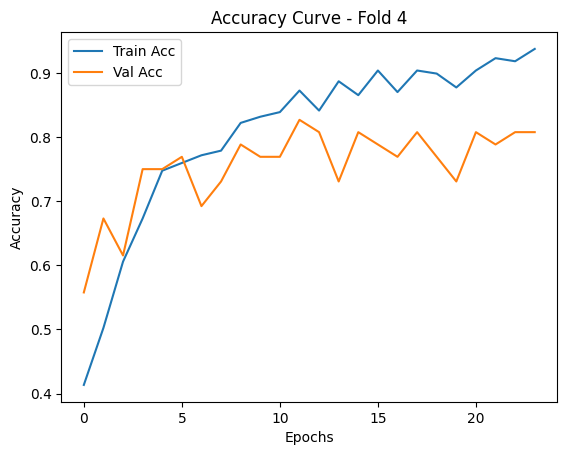

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 594ms/step

--- Fold 5 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3687 - loss: 9.9264 
Epoch 1: val_loss improved from inf to 1.06880, saving model to best_model_fold5.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.3689 - loss: 9.8537 - val_accuracy: 0.6154 - val_loss: 1.0688
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5051 - loss: 2.0037
Epoch 2: val_loss improved from 1.06880 to 0.65586, saving model to best_model_fold5.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.5062 - loss: 1.9969 - val_accuracy: 0.8269 - val_loss: 0.6559
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6433 - loss: 1.1176
Epoch 3: val_loss improved from 0.65586 to 0.53673, saving model to best_model_fold5.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.6429 - loss: 1.1182 - val_accuracy: 0.7885 - val_loss: 0.5367
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6862 - loss: 0.9000
Epoch 4: val_loss did not improve from 0.53673
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.6862 - loss: 0.8999 - val_accuracy: 0.7500 - val_loss: 0.7378
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7195 - loss: 0.7577
Epoch 5: val_loss did not improve from 0.53673
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7196 - loss: 0.7584 - val_accuracy: 0.8462 - val_loss: 0.5925
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7478 - loss: 0.6798
Epoch 6: val_loss did not improve from 0.53673
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.7480 - loss: 0.6806 - val_accuracy: 0.7885 - val_loss: 0.8541
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7368 - loss: 0.7484
Epoch 7: val_loss did not improve from 0.5

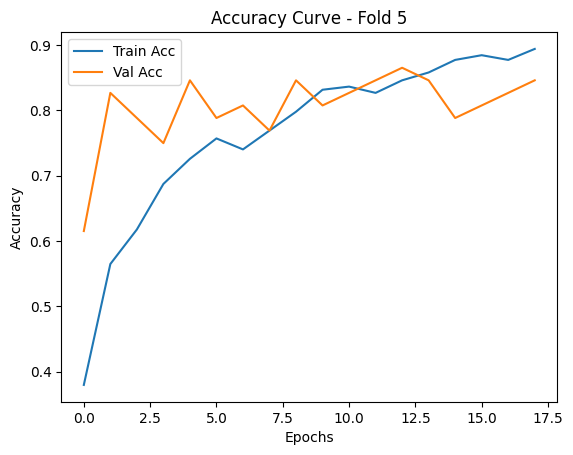

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 590ms/step

===== Fold-based CV Results (mean ± std) =====
accuracy: 0.7538 ± 0.0937
precision: 0.7650 ± 0.0889
recall: 0.7538 ± 0.0937
f1: 0.7519 ± 0.0922
auc: 0.9276 ± 0.0390

===== Pooled Metrics (95% CI via bootstrapping) =====
Accuracy: 0.754 (95% CI: 0.700–0.804)
Precision: 0.756 (95% CI: 0.703–0.810)
Recall: 0.753 (95% CI: 0.698–0.804)
F1-score: 0.752 (95% CI: 0.699–0.804)
AUC: 0.919 (95% CI: 0.892–0.943)


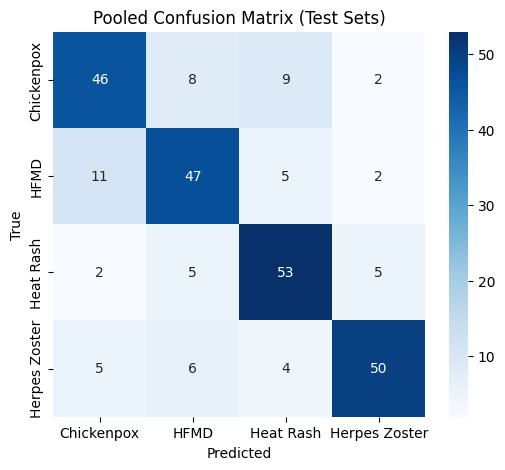


===== Per-Class Metrics (Pooled) =====
Chickenpox      | Precision: 0.719 Recall: 0.708 F1: 0.713
HFMD            | Precision: 0.712 Recall: 0.723 F1: 0.718
Heat Rash       | Precision: 0.746 Recall: 0.815 F1: 0.779
Herpes Zoster   | Precision: 0.847 Recall: 0.769 F1: 0.806


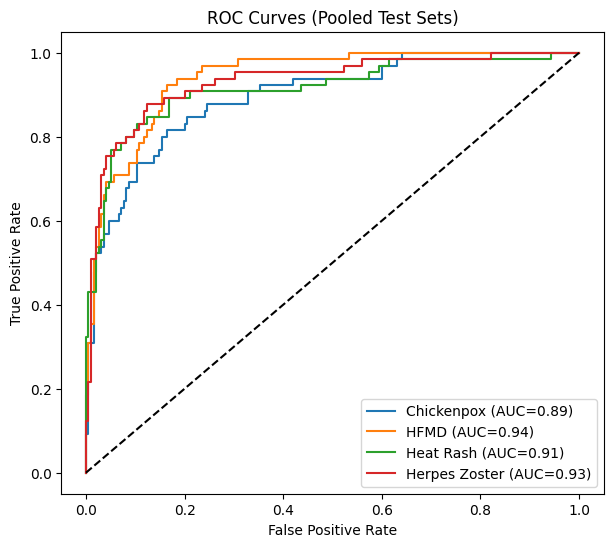

In [ ]:
class_names = ["Chickenpox", "HFMD", "Heat Rash", "Herpes Zoster"]

# Run with augmentation
run_experiment(X, y, class_names, use_aug=True, subset_frac=1.0, epochs=100)

#Without augmentation


--- Fold 1 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3418 - loss: 10.7344
Epoch 1: val_loss improved from inf to 1.11098, saving model to best_model_fold1.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.3453 - loss: 10.5365 - val_accuracy: 0.6923 - val_loss: 1.1110
Epoch 2/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8077 - loss: 0.8144
Epoch 2: val_loss did not improve from 1.11098
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8059 - loss: 0.8229 - val_accuracy: 0.6346 - val_loss: 1.6603
Epoch 3/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9238 - loss: 0.2018
Epoch 3: val_loss did not improve from 1.11098
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9230 - loss: 0.2061 - val_accuracy: 0.6154 - val_loss: 1.7024
Epoch 4/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9581 - loss: 0.1565
Epoch 4: val_loss did not improve from 1.11098
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9574 - loss: 0.1586 - val_accuracy: 0.6346 - val_loss: 1.9755
Epoch 5/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9918 - loss: 0.0381
Epoch 5: val_loss did not improve from 1.11098
5

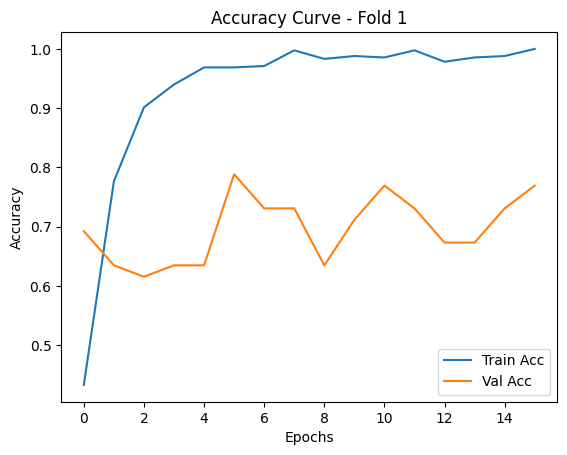

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 593ms/step

--- Fold 2 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3895 - loss: 8.7468
Epoch 1: val_loss improved from inf to 4.23867, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.3918 - loss: 8.6060 - val_accuracy: 0.3077 - val_loss: 4.2387
Epoch 2/100
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7552 - loss: 1.0594
Epoch 2: val_loss improved from 4.23867 to 2.11557, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7572 - loss: 1.0439 - val_accuracy: 0.4423 - val_loss: 2.1156
Epoch 3/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9417 - loss: 0.2617
Epoch 3: val_loss improved from 2.11557 to 1.90797, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9398 - loss: 0.2708 - val_accuracy: 0.6154 - val_loss: 1.9080
Epoch 4/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9233 - loss: 0.2136
Epoch 4: val_loss improved from 1.90797 to 1.27010, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9233 - loss: 0.2180 - val_accuracy: 0.6538 - val_loss: 1.2701
Epoch 5/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9936 - loss: 0.0404
Epoch 5: val_loss did not improve from 1.27010
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9926 - loss: 0.0423 - val_accuracy: 0.4808 - val_loss: 4.7695
Epoch 6/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9445 - loss: 0.1912
Epoch 6: val_loss improved from 1.27010 to 1.08636, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9447 - loss: 0.1902 - val_accuracy: 0.7308 - val_loss: 1.0864
Epoch 7/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9983 - loss: 0.0116
Epoch 7: val_loss did not improve from 1.08636
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9979 - loss: 0.0134 - val_accuracy: 0.6923 - val_loss: 1.3463
Epoch 8/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9986 - loss: 0.0060
Epoch 8: val_loss improved from 1.08636 to 0.75989, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9985 - loss: 0.0063 - val_accuracy: 0.7885 - val_loss: 0.7599
Epoch 9/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9870 - loss: 0.0795
Epoch 9: val_loss improved from 0.75989 to 0.74725, saving model to best_model_fold2.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9871 - loss: 0.0797 - val_accuracy: 0.7885 - val_loss: 0.7472
Epoch 10/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9910 - loss: 0.0249
Epoch 10: val_loss did not improve from 0.74725
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9909 - loss: 0.0250 - val_accuracy: 0.6923 - val_loss: 1.1734
Epoch 11/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9939 - loss: 0.0167
Epoch 11: val_loss did not improve from 0.74725
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9936 - loss: 0.0177 - val_accuracy: 0.6731 - val_loss: 1.3717
Epoch 12/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9965 - loss: 0.0041
Epoch 12: val_loss did not improve from 0.74725
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9966 - loss: 0.0041 - val_accuracy: 0.7692 - val_loss: 0.8102
Epoch 13/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9881 - loss: 0.0442
Epoch 13: val_loss did not improve from 0.74

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 1.0000 - loss: 2.3480e-04 - val_accuracy: 0.7885 - val_loss: 0.6921
Epoch 20/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.5756e-04
Epoch 20: val_loss did not improve from 0.69210
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.7379e-04 - val_accuracy: 0.7692 - val_loss: 0.9348
Epoch 21/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.2535e-05
Epoch 21: val_loss did not improve from 0.69210
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.2192e-05 - val_accuracy: 0.7500 - val_loss: 0.8741
Epoch 22/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.1181e-05
Epoch 22: val_loss did not improve from 0.69210
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.1495e-05 - val_accuracy: 0.7500 - val_loss: 0.9243
Epoch 23/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.4219e-05
Epoch 23: va

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 1.0000 - loss: 7.6261e-05 - val_accuracy: 0.7692 - val_loss: 0.6814
Epoch 24/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.8646e-05
Epoch 24: val_loss did not improve from 0.68142
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 7.7790e-05 - val_accuracy: 0.7885 - val_loss: 0.6937
Epoch 25/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.4291e-04
Epoch 25: val_loss did not improve from 0.68142
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.4028e-04 - val_accuracy: 0.7885 - val_loss: 0.7703
Epoch 26/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 7.1348e-06
Epoch 26: val_loss did not improve from 0.68142
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 7.2134e-06 - val_accuracy: 0.7692 - val_loss: 0.7958
Epoch 27/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 9.0923e-06
Epoch 27: va

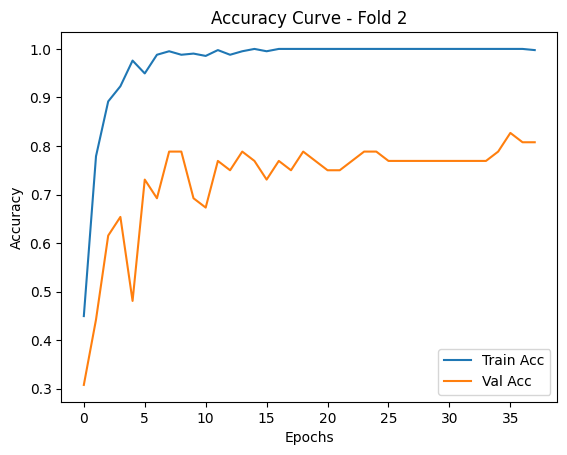

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 589ms/step

--- Fold 3 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3454 - loss: 10.3175
Epoch 1: val_loss improved from inf to 2.02860, saving model to best_model_fold3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.3502 - loss: 10.0511 - val_accuracy: 0.5192 - val_loss: 2.0286
Epoch 2/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7782 - loss: 0.7925
Epoch 2: val_loss did not improve from 2.02860
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7783 - loss: 0.7984 - val_accuracy: 0.4423 - val_loss: 3.3845
Epoch 3/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9015 - loss: 0.3908
Epoch 3: val_loss did not improve from 2.02860
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9004 - loss: 0.3981 - val_accuracy: 0.5192 - val_loss: 3.0096
Epoch 4/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9188 - loss: 0.2891
Epoch 4: val_loss improved from 2.02860 to 1.59944, saving model to best_model_fold3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9196 - loss: 0.2827 - val_accuracy: 0.7692 - val_loss: 1.5994
Epoch 5/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9626 - loss: 0.1473
Epoch 5: val_loss did not improve from 1.59944
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9626 - loss: 0.1492 - val_accuracy: 0.6923 - val_loss: 1.8856
Epoch 6/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9849 - loss: 0.0520
Epoch 6: val_loss did not improve from 1.59944
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9847 - loss: 0.0524 - val_accuracy: 0.6923 - val_loss: 1.7477
Epoch 7/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9593 - loss: 0.1998
Epoch 7: val_loss improved from 1.59944 to 1.53882, saving model to best_model_fold3.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9593 - loss: 0.1995 - val_accuracy: 0.6923 - val_loss: 1.5388
Epoch 8/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9788 - loss: 0.0685
Epoch 8: val_loss did not improve from 1.53882
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9789 - loss: 0.0682 - val_accuracy: 0.6923 - val_loss: 1.6656
Epoch 9/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9966 - loss: 0.0101
Epoch 9: val_loss did not improve from 1.53882
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9963 - loss: 0.0110 - val_accuracy: 0.6346 - val_loss: 2.4176
Epoch 10/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9769 - loss: 0.0659
Epoch 10: val_loss did not improve from 1.53882
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9771 - loss: 0.0653 - val_accuracy: 0.7692 - val_loss: 1.7963
Epoch 11/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9904 - loss: 0.0427
Epoch 11: val_loss did not improve from 1.53882

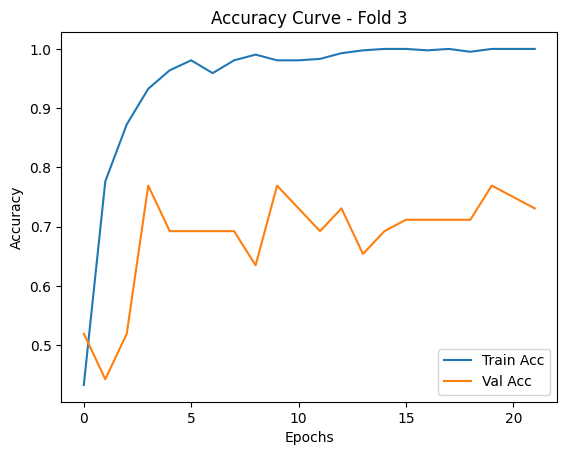

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 590ms/step

--- Fold 4 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3383 - loss: 11.4304
Epoch 1: val_loss improved from inf to 1.61214, saving model to best_model_fold4.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.3414 - loss: 11.1975 - val_accuracy: 0.5000 - val_loss: 1.6121
Epoch 2/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7609 - loss: 0.6755
Epoch 2: val_loss improved from 1.61214 to 0.93434, saving model to best_model_fold4.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7612 - loss: 0.6758 - val_accuracy: 0.7308 - val_loss: 0.9343
Epoch 3/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9351 - loss: 0.2328
Epoch 3: val_loss did not improve from 0.93434
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9346 - loss: 0.2345 - val_accuracy: 0.7500 - val_loss: 0.9803
Epoch 4/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9399 - loss: 0.1637
Epoch 4: val_loss improved from 0.93434 to 0.88631, saving model to best_model_fold4.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9401 - loss: 0.1650 - val_accuracy: 0.8269 - val_loss: 0.8863
Epoch 5/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9842 - loss: 0.0951
Epoch 5: val_loss did not improve from 0.88631
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9840 - loss: 0.0950 - val_accuracy: 0.7115 - val_loss: 1.4704
Epoch 6/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9705 - loss: 0.0661
Epoch 6: val_loss did not improve from 0.88631
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9707 - loss: 0.0660 - val_accuracy: 0.7885 - val_loss: 1.1871
Epoch 7/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9875 - loss: 0.0539
Epoch 7: val_loss did not improve from 0.88631
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9870 - loss: 0.0554 - val_accuracy: 0.7692 - val_loss: 1.2942
Epoch 8/100
49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 8: val_loss did not improve from 0.88631
52/5

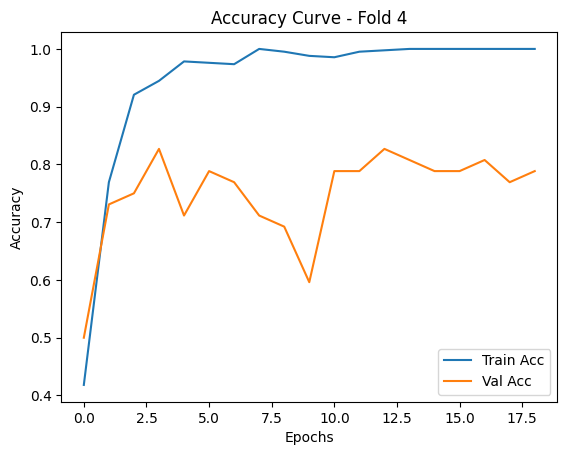

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 600ms/step

--- Fold 5 ---
Train: 416 (80.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3537 - loss: 10.8797
Epoch 1: val_loss improved from inf to 1.32444, saving model to best_model_fold5.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.3611 - loss: 10.3865 - val_accuracy: 0.5577 - val_loss: 1.3244
Epoch 2/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8084 - loss: 0.7097
Epoch 2: val_loss improved from 1.32444 to 0.92669, saving model to best_model_fold5.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8081 - loss: 0.7130 - val_accuracy: 0.7500 - val_loss: 0.9267
Epoch 3/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8740 - loss: 0.3551
Epoch 3: val_loss did not improve from 0.92669
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8745 - loss: 0.3554 - val_accuracy: 0.8077 - val_loss: 0.9473
Epoch 4/100
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9248 - loss: 0.1947
Epoch 4: val_loss did not improve from 0.92669
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9243 - loss: 0.2018 - val_accuracy: 0.7115 - val_loss: 2.2244
Epoch 5/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9583 - loss: 0.1553
Epoch 5: val_loss did not improve from 0.92669
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9578 - loss: 0.1583 - val_accuracy: 0.7692 - val_loss: 1.1146
Epoch 6/100
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9508 - loss: 0.1658
Epoch 6: val_loss improved from 0.92669 to 0.79172,

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9492 - loss: 0.1727 - val_accuracy: 0.8269 - val_loss: 0.7917
Epoch 7/100
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9549 - loss: 0.1225
Epoch 7: val_loss did not improve from 0.79172
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9561 - loss: 0.1227 - val_accuracy: 0.8462 - val_loss: 0.8077
Epoch 8/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9950 - loss: 0.0327
Epoch 8: val_loss did not improve from 0.79172
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9946 - loss: 0.0346 - val_accuracy: 0.8077 - val_loss: 0.9493
Epoch 9/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9942 - loss: 0.0200
Epoch 9: val_loss did not improve from 0.79172
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9940 - loss: 0.0205 - val_accuracy: 0.7692 - val_loss: 1.2688
Epoch 10/100
48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.4132e-04
Epoch 10: val_loss did not improve from 0.7917

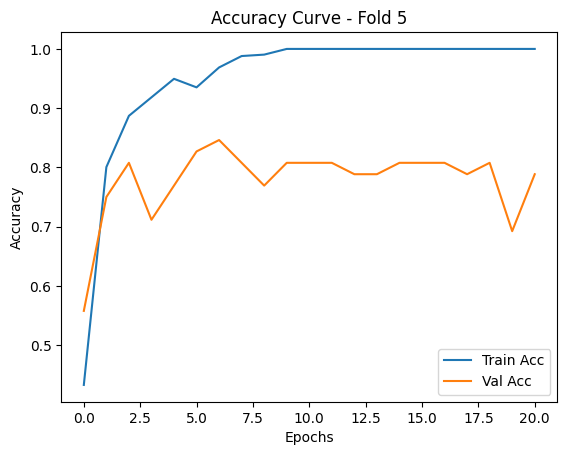

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 599ms/step

===== Fold-based CV Results (mean ± std) =====
accuracy: 0.7346 ± 0.0937
precision: 0.7661 ± 0.0646
recall: 0.7346 ± 0.0937
f1: 0.7235 ± 0.0998
auc: 0.9201 ± 0.0390

===== Pooled Metrics (95% CI via bootstrapping) =====
Accuracy: 0.735 (95% CI: 0.681–0.785)
Precision: 0.735 (95% CI: 0.683–0.784)
Recall: 0.737 (95% CI: 0.682–0.788)
F1-score: 0.731 (95% CI: 0.678–0.784)
AUC: 0.908 (95% CI: 0.878–0.935)


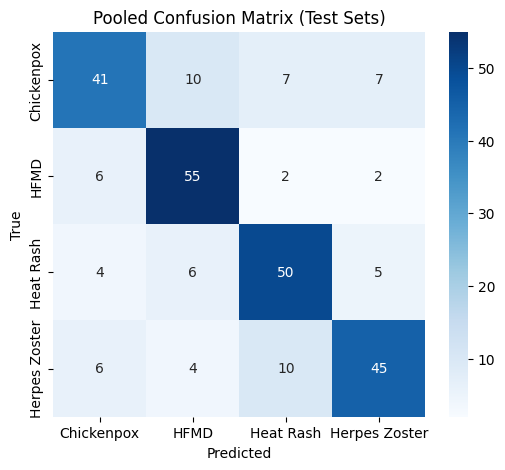


===== Per-Class Metrics (Pooled) =====
Chickenpox      | Precision: 0.719 Recall: 0.631 F1: 0.672
HFMD            | Precision: 0.733 Recall: 0.846 F1: 0.786
Heat Rash       | Precision: 0.725 Recall: 0.769 F1: 0.746
Herpes Zoster   | Precision: 0.763 Recall: 0.692 F1: 0.726


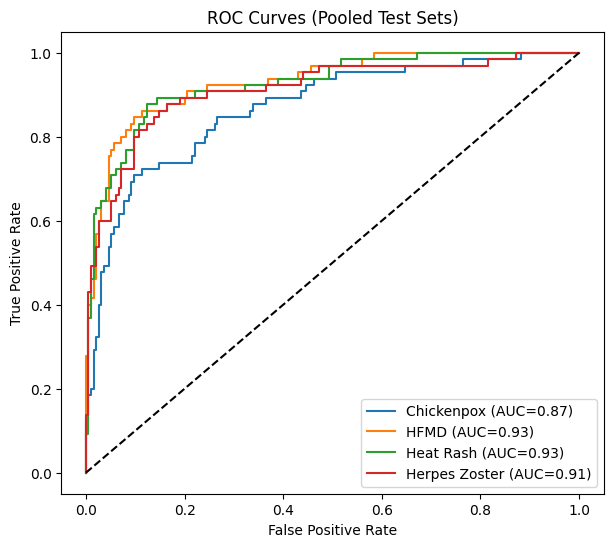

In [ ]:
# Run without augmentation
run_experiment(X, y, class_names, use_aug=False, subset_frac=1.0, epochs=100)


#With augmentation & 50% of training data


--- Fold 1 ---
Train: 208 (40.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3178 - loss: 12.2733
Epoch 1: val_loss improved from inf to 4.45481, saving model to best_model_fold1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 504ms/step - accuracy: 0.3194 - loss: 12.1335 - val_accuracy: 0.3462 - val_loss: 4.4548
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5681 - loss: 2.3615
Epoch 2: val_loss improved from 4.45481 to 1.86846, saving model to best_model_fold1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.5669 - loss: 2.3693 - val_accuracy: 0.5385 - val_loss: 1.8685
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6413 - loss: 1.5578
Epoch 3: val_loss improved from 1.86846 to 1.77080, saving model to best_model_fold1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.6421 - loss: 1.5509 - val_accuracy: 0.6538 - val_loss: 1.7708
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6654 - loss: 1.4700
Epoch 4: val_loss did not improve from 1.77080
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6662 - loss: 1.4660 - val_accuracy: 0.4231 - val_loss: 2.7434
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6424 - loss: 1.3903
Epoch 5: val_loss improved from 1.77080 to 1.03641, saving model to best_model_fold1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.6452 - loss: 1.3789 - val_accuracy: 0.7308 - val_loss: 1.0364
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8243 - loss: 0.7460
Epoch 6: val_loss did not improve from 1.03641
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.8235 - loss: 0.7501 - val_accuracy: 0.5000 - val_loss: 2.3565
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7069 - loss: 1.0352
Epoch 7: val_loss improved from 1.03641 to 1.00483, saving model to best_model_fold1.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.7075 - loss: 1.0357 - val_accuracy: 0.6731 - val_loss: 1.0048
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7760 - loss: 0.5629
Epoch 8: val_loss did not improve from 1.00483
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7755 - loss: 0.5660 - val_accuracy: 0.6923 - val_loss: 1.4798
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8368 - loss: 0.4332
Epoch 9: val_loss did not improve from 1.00483
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8365 - loss: 0.4350 - val_accuracy: 0.5385 - val_loss: 2.6640
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7053 - loss: 0.9298
Epoch 10: val_loss did not improve from 1.00483
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7084 - loss: 0.9218 - val_accuracy: 0.7500 - val_loss: 1.2475
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8805 - loss: 0.3309
Epoch 11: val_loss did not improve from 

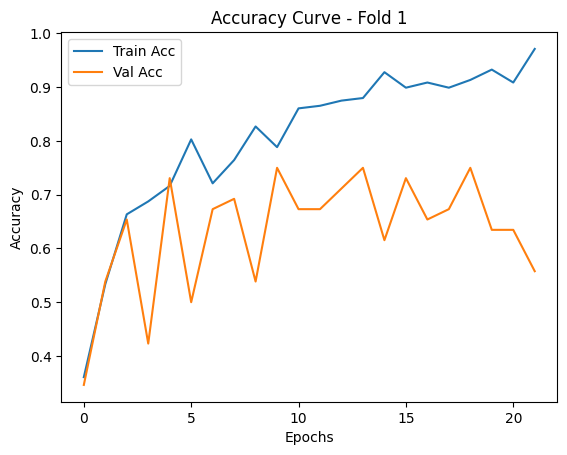

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 606ms/step

--- Fold 2 ---
Train: 208 (40.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3125 - loss: 14.6962
Epoch 1: val_loss improved from inf to 1.03848, saving model to best_model_fold2.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - accuracy: 0.3146 - loss: 14.4894 - val_accuracy: 0.6346 - val_loss: 1.0385
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4993 - loss: 2.4710
Epoch 2: val_loss did not improve from 1.03848
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.4999 - loss: 2.4710 - val_accuracy: 0.5385 - val_loss: 1.4994
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6139 - loss: 1.4251
Epoch 3: val_loss did not improve from 1.03848
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6145 - loss: 1.4299 - val_accuracy: 0.4615 - val_loss: 2.1826
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7104 - loss: 1.0402
Epoch 4: val_loss did not improve from 1.03848
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7078 - loss: 1.0546 - val_accuracy: 0.6154 - val_loss: 1.1359
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7630 - loss: 0.7854
Epoch 5: val_loss improved from 1.03848 t

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.7613 - loss: 0.7940 - val_accuracy: 0.7692 - val_loss: 0.6448
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7719 - loss: 0.8178
Epoch 6: val_loss did not improve from 0.64484
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.7718 - loss: 0.8173 - val_accuracy: 0.4038 - val_loss: 2.0421
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6717 - loss: 1.0556
Epoch 7: val_loss did not improve from 0.64484
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.6732 - loss: 1.0489 - val_accuracy: 0.5962 - val_loss: 1.2443
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7614 - loss: 0.6773
Epoch 8: val_loss did not improve from 0.64484
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.7615 - loss: 0.6788 - val_accuracy: 0.6923 - val_loss: 0.7663
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8408 - loss: 0.4530
Epoch 9: val_loss did not improve from 0.64

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.8603 - loss: 0.4051 - val_accuracy: 0.8269 - val_loss: 0.5998
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9129 - loss: 0.3028
Epoch 13: val_loss did not improve from 0.59977
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9124 - loss: 0.3051 - val_accuracy: 0.8077 - val_loss: 0.6551
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8829 - loss: 0.4693
Epoch 14: val_loss did not improve from 0.59977
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.8827 - loss: 0.4674 - val_accuracy: 0.5385 - val_loss: 1.3814
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9045 - loss: 0.2746
Epoch 15: val_loss did not improve from 0.59977
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9036 - loss: 0.2783 - val_accuracy: 0.7500 - val_loss: 1.0853
Epoch 16/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8459 - loss: 0.4770
Epoch 16: val_loss did not improve f

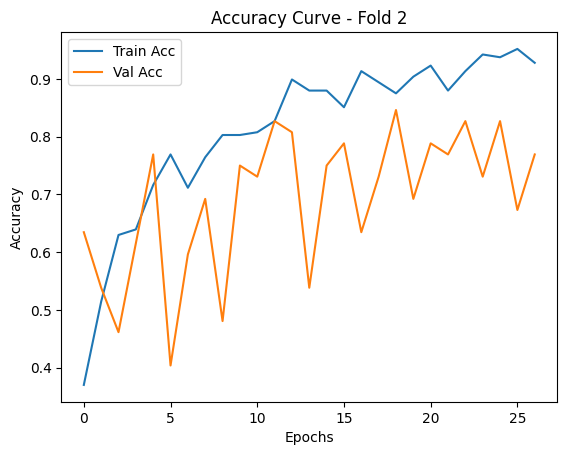

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 609ms/step

--- Fold 3 ---
Train: 208 (40.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3034 - loss: 13.1061
Epoch 1: val_loss improved from inf to 2.65036, saving model to best_model_fold3.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 504ms/step - accuracy: 0.3050 - loss: 12.9423 - val_accuracy: 0.4423 - val_loss: 2.6504
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5928 - loss: 1.6981
Epoch 2: val_loss did not improve from 2.65036
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.5898 - loss: 1.7152 - val_accuracy: 0.3846 - val_loss: 5.1444
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5710 - loss: 2.1101
Epoch 3: val_loss improved from 2.65036 to 1.70479, saving model to best_model_fold3.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.5717 - loss: 2.0982 - val_accuracy: 0.4808 - val_loss: 1.7048
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5847 - loss: 1.4364
Epoch 4: val_loss improved from 1.70479 to 1.03580, saving model to best_model_fold3.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.5862 - loss: 1.4291 - val_accuracy: 0.6346 - val_loss: 1.0358
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7273 - loss: 0.9505
Epoch 5: val_loss did not improve from 1.03580
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.7271 - loss: 0.9522 - val_accuracy: 0.5192 - val_loss: 1.9088
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6712 - loss: 0.8721
Epoch 6: val_loss did not improve from 1.03580
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.6733 - loss: 0.8688 - val_accuracy: 0.6346 - val_loss: 1.0618
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6822 - loss: 1.0099
Epoch 7: val_loss did not improve from 1.03580
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6827 - loss: 1.0057 - val_accuracy: 0.5962 - val_loss: 1.9711
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8137 - loss: 0.6226
Epoch 8: val_loss did not improve from 1.03

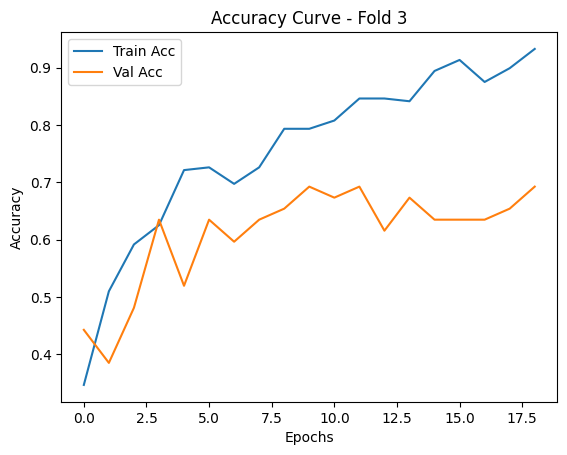

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 602ms/step

--- Fold 4 ---
Train: 208 (40.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2427 - loss: 15.5783
Epoch 1: val_loss improved from inf to 2.18795, saving model to best_model_fold4.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - accuracy: 0.2433 - loss: 15.3264 - val_accuracy: 0.4038 - val_loss: 2.1879
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3799 - loss: 2.2847
Epoch 2: val_loss improved from 2.18795 to 0.87845, saving model to best_model_fold4.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.3820 - loss: 2.2704 - val_accuracy: 0.6731 - val_loss: 0.8784
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6253 - loss: 1.0379
Epoch 3: val_loss did not improve from 0.87845
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6222 - loss: 1.0493 - val_accuracy: 0.2885 - val_loss: 2.6181
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4901 - loss: 1.4401
Epoch 4: val_loss did not improve from 0.87845
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.4912 - loss: 1.4323 - val_accuracy: 0.6731 - val_loss: 0.9332
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6878 - loss: 0.9110
Epoch 5: val_loss did not improve from 0.87845
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6867 - loss: 0.9169 - val_accuracy: 0.6346 - val_loss: 1.0760
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6758 - loss: 0.9385
Epoch 6: val_loss did not improve from 0.87

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.7890 - loss: 0.6108 - val_accuracy: 0.6923 - val_loss: 0.8417
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7991 - loss: 0.6091
Epoch 8: val_loss did not improve from 0.84166
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.7993 - loss: 0.6073 - val_accuracy: 0.6731 - val_loss: 1.1790
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7719 - loss: 0.6941
Epoch 9: val_loss improved from 0.84166 to 0.82036, saving model to best_model_fold4.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.7716 - loss: 0.6919 - val_accuracy: 0.7308 - val_loss: 0.8204
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8320 - loss: 0.5773
Epoch 10: val_loss did not improve from 0.82036
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.8330 - loss: 0.5734 - val_accuracy: 0.6923 - val_loss: 0.9997
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7667 - loss: 0.5911
Epoch 11: val_loss did not improve from 0.82036
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.7671 - loss: 0.5919 - val_accuracy: 0.6923 - val_loss: 1.0075
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7994 - loss: 0.6083
Epoch 12: val_loss did not improve from 0.82036
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7995 - loss: 0.6061 - val_accuracy: 0.7500 - val_loss: 0.8585
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8249 - loss: 0.5418
Epoch 13: val_loss did not improve f

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.9186 - loss: 0.3630 - val_accuracy: 0.7308 - val_loss: 0.7990
Epoch 17/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8659 - loss: 0.3872
Epoch 17: val_loss did not improve from 0.79904
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.8650 - loss: 0.3902 - val_accuracy: 0.6731 - val_loss: 1.1245
Epoch 18/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8429 - loss: 0.5238
Epoch 18: val_loss did not improve from 0.79904
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.8443 - loss: 0.5223 - val_accuracy: 0.7308 - val_loss: 1.1609
Epoch 19/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9471 - loss: 0.1874
Epoch 19: val_loss did not improve from 0.79904
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9464 - loss: 0.1885 - val_accuracy: 0.7115 - val_loss: 1.3944
Epoch 20/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9693 - loss: 0.1356
Epoch 20: val_loss did not improve f

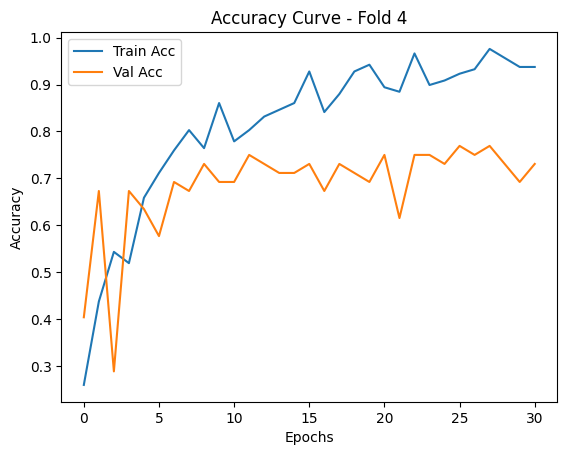

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 601ms/step

--- Fold 5 ---
Train: 208 (40.0%)
Val: 52 (10.0%)
Test: 52 (10.0%)
Verification - Test set labels match: True


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3425 - loss: 13.0552
Epoch 1: val_loss improved from inf to 1.96237, saving model to best_model_fold5.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - accuracy: 0.3434 - loss: 12.8875 - val_accuracy: 0.5192 - val_loss: 1.9624
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4632 - loss: 3.0786
Epoch 2: val_loss improved from 1.96237 to 0.90844, saving model to best_model_fold5.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.4640 - loss: 3.0618 - val_accuracy: 0.6538 - val_loss: 0.9084
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5198 - loss: 1.9598
Epoch 3: val_loss did not improve from 0.90844
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5203 - loss: 1.9568 - val_accuracy: 0.5962 - val_loss: 1.0141
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6987 - loss: 1.1130
Epoch 4: val_loss improved from 0.90844 to 0.66675, saving model to best_model_fold5.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.6964 - loss: 1.1208 - val_accuracy: 0.7885 - val_loss: 0.6668
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7903 - loss: 0.7603
Epoch 5: val_loss did not improve from 0.66675
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.7881 - loss: 0.7674 - val_accuracy: 0.7308 - val_loss: 0.7150
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7648 - loss: 0.6865
Epoch 6: val_loss did not improve from 0.66675
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.7628 - loss: 0.6938 - val_accuracy: 0.7308 - val_loss: 0.6699
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8186 - loss: 0.5252
Epoch 7: val_loss did not improve from 0.66675
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.8173 - loss: 0.5302 - val_accuracy: 0.7885 - val_loss: 0.7830
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7531 - loss: 0.8637
Epoch 8: val_loss did not improve from 0.66

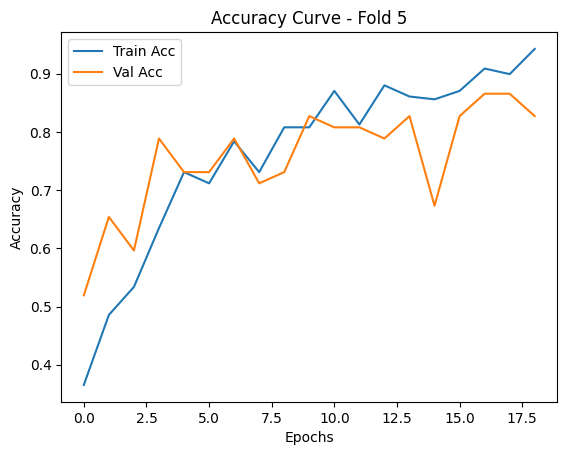

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 785ms/step

===== Fold-based CV Results (mean ± std) =====
accuracy: 0.6731 ± 0.0272
precision: 0.6996 ± 0.0247
recall: 0.6731 ± 0.0272
f1: 0.6618 ± 0.0333
auc: 0.8959 ± 0.0354

===== Pooled Metrics (95% CI via bootstrapping) =====
Accuracy: 0.673 (95% CI: 0.612–0.731)
Precision: 0.683 (95% CI: 0.625–0.735)
Recall: 0.673 (95% CI: 0.621–0.728)
F1-score: 0.670 (95% CI: 0.614–0.723)
AUC: 0.877 (95% CI: 0.846–0.907)


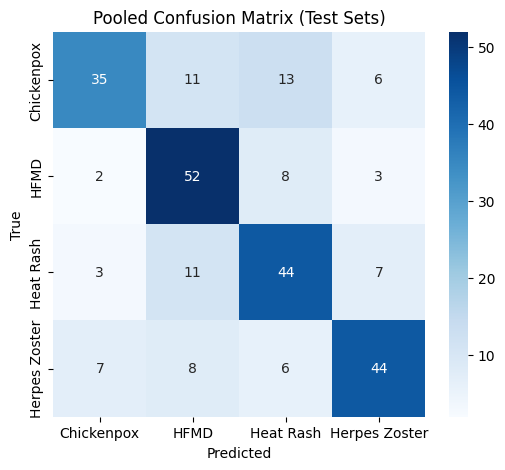


===== Per-Class Metrics (Pooled) =====
Chickenpox      | Precision: 0.745 Recall: 0.538 F1: 0.625
HFMD            | Precision: 0.634 Recall: 0.800 F1: 0.707
Heat Rash       | Precision: 0.620 Recall: 0.677 F1: 0.647
Herpes Zoster   | Precision: 0.733 Recall: 0.677 F1: 0.704


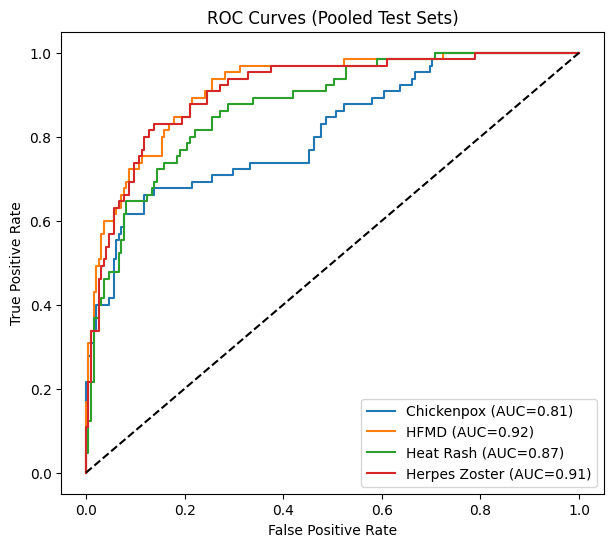

In [ ]:
# Run on smaller subset (e.g., 50% of training data)
run_experiment(X, y, class_names, use_aug=True, subset_frac=0.5, epochs=100)
